<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/master/brisque_downstream_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil
from zipfile import ZipFile

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

Mounted at /content/drive


In [2]:
import os

# Clone repo and copy in images. change working directory to repo's wildtrack branch
!git clone https://github.com/WildTrackAI/wildtrack-iqa.git
%cd "wildtrack-iqa"

# copy data files from share  if needed, comment out if already in working directory
shutil.copy( PARENT_DIR + '/data/training_image_references.csv','training_image_references.csv') 
shutil.copy( PARENT_DIR + '/data/validation_image_references.csv','validation_image_references.csv') 
shutil.copy( PARENT_DIR + '/data/testing_image_references.csv','testing_image_references.csv') 


Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 143 (delta 37), reused 27 (delta 21), pack-reused 85
Receiving objects: 100% (143/143), 2.66 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/wildtrack-iqa


'testing_image_references.csv'

In [3]:
%cd "/content/wildtrack-iqa/multitask"
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 
import os
root_dir = '/content/wildtrack-iqa'
data_dir = root_dir + '/RAW'
image_reference_file_suffix = '_image_references.csv'

/content/wildtrack-iqa/multitask


In [4]:
import shutil
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import random
from network import NSSADNN
from WildTrackDataset import WildTrackDataset


In [5]:

save_model = root_dir + "/model.pth"

seed = random.randint(10000000, 99999999)

torch.manual_seed(seed)
np.random.seed(seed)
print("seed:", seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

binary_threshold = 4
train_dataset = WildTrackDataset(root_dir + '/' + 'training' + image_reference_file_suffix, binary_threshold)
val_dataset = WildTrackDataset(root_dir + '/' + 'validation' + image_reference_file_suffix, binary_threshold)
test_dataset = WildTrackDataset(root_dir + '/' + 'testing' + image_reference_file_suffix, binary_threshold)

seed: 88386660


/content/wildtrack-iqa/multitask/WildTrackDataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_features['species'] = images['species'].apply(lambda x: self.categories[x])


In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
batch_size = 64
epochs = 3000
lr = 0.000001

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=0,  drop_last=True )

val_loader = torch.utils.data.DataLoader(val_dataset)
valnum = len(val_dataset.label)


test_loader = torch.utils.data.DataLoader(test_dataset)
testnum = len(test_dataset.label)

model = NSSADNN().to(device)
classify_criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)
best_SROCC = -1

# training 
for epoch in range(epochs):
      # train
      model.train()
      LOSS_all = 0
      for i, (label, features) in enumerate(train_loader):
          label = label.type(torch.FloatTensor) 
          label = label.to(device).reshape(-1,1)
          features = features.to(device).float()
          optimizer.zero_grad()
          results = model(features)         
          loss = classify_criterion(results, label)
          loss.backward()
          optimizer.step()
          LOSS_all += float(loss.item())
          
      train_loss_all = LOSS_all / (i + 1)
      
      
      # val
      y_pred = np.zeros(valnum)
      y_val = np.zeros(valnum)
      model.eval()
      L = 0
      with torch.no_grad():
          for i, (label, features) in enumerate(val_loader):
              label = label.type(torch.FloatTensor) 
              label = label.to(device).reshape(-1,1)
              y_val[i] = label.item()
              features = features.to(device).float()
              results = model(features)
              y_pred[i] = (results > .5).float() * 1 
              loss = classify_criterion(results, label)
              L = L + loss.item()
      
          val_loss = L / (i + 1)
          val_SROCC = stats.spearmanr(y_pred, y_val)[0]
          val_PLCC = stats.pearsonr(y_pred, y_val)[0]
          val_KROCC = stats.stats.kendalltau(y_pred, y_val)[0]
          val_RMSE = np.sqrt(((y_pred - y_val) ** 2).mean())

           
      print("Epoch {}".format(epoch))

      if val_SROCC > best_SROCC and epoch > 50:
          print("Update Epoch {} best valid SROCC".format(epoch))
          print("Valid Results: loss={:.3f} SROCC={:.3f} PLCC={:.3f} KROCC={:.3f} RMSE={:.3f}".format(val_loss,
                                                                                                      val_SROCC,
                                                                                                      val_PLCC,
                                                                                                      val_KROCC,
                                                                                                      val_RMSE))          
          torch.save(model.state_dict(), save_model)
          shutil.copy(save_model, PARENT_DIR + '/data/model.pth')
          best_SROCC = val_SROCC

      #scheduler.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Update Epoch 51 best valid SROCC
Valid Results: loss=0.817 SROCC=0.252 PLCC=0.252 KROCC=0.252 RMSE=0.654
Epoch 52
Epoch 53
Update Epoch 53 best valid SROCC
Valid Results: loss=0.805 SROCC=0.271 PLCC=0.271 KROCC=0.271 RMSE=0.637
Epoch 54
Update Epoch 54 best valid SROCC
Valid Results: loss=0.828 SROCC=0.274 PLCC=0.274 KROCC=0.274 RMSE=0.629
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Update Epoch 62 best valid SROCC
Valid Results: loss=0.718 SROCC=0.278 PLCC=0.278 KROCC=0.278 RMSE=0.569
Epoch 63
Update Epoch 6

KeyboardInterrupt: ignored

In [7]:
shutil.copy(PARENT_DIR + '/data/model.pth', save_model)
model.load_state_dict(torch.load(save_model))

model.eval()
with torch.no_grad():
    y_pred = np.zeros(testnum)
    y_test = np.zeros(testnum)
    L = 0
    for i, ( label, features) in enumerate(test_loader):
        y_test[i] = label.item()
        label = label.to(device)
        features = features.to(device).float()
        results = model(features)
        y_pred[i] = (results > .5).float() * 1 
        loss = classify_criterion(results, label)
        L = L + loss.item()
test_loss = L / (i + 1)
SROCC = stats.spearmanr(y_pred, y_test)[0]
PLCC = stats.pearsonr(y_pred, y_test)[0]
KROCC = stats.stats.kendalltau(y_pred, y_test)[0]
RMSE = np.sqrt(((y_pred - y_test) ** 2).mean())

print(y_test)
print(y_pred)

print("Final test Results: loss={:.3f} SROCC={:.3f} PLCC={:.3f} KROCC={:.3f} RMSE={:.3f}".format(test_loss, SROCC, PLCC, KROCC, RMSE))


[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.

In [8]:
from sklearn.metrics import classification_report

y_test_anomaly = np.array([1 if y == 0 else 0 for y in y_test])
y_pred_anomaly = np.array([1 if y == 0 else 0 for y in y_pred])
print(classification_report(y_test_anomaly, y_pred_anomaly))

              precision    recall  f1-score   support

           0       0.94      0.63      0.76       595
           1       0.28      0.79      0.41       107

    accuracy                           0.66       702
   macro avg       0.61      0.71      0.59       702
weighted avg       0.84      0.66      0.71       702



Text(0.5, 0, 'Recall')

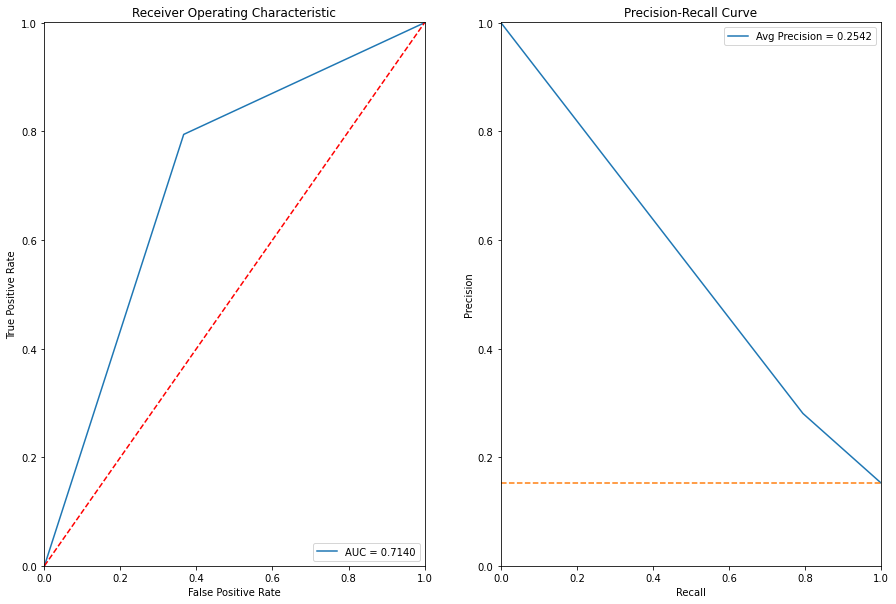

In [9]:
# Create a ROC and Precision Curve to assess how well we can claassify based on mse
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , roc_auc_score, roc_curve, auc, classification_report, average_precision_score, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test_anomaly, y_pred_anomaly)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test_anomaly, y_pred_anomaly)
avg_pr = average_precision_score(y_test_anomaly, y_pred_anomaly)

no_skill = len(y_test_anomaly[y_test_anomaly==1]) / len(y_test_anomaly)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Receiver Operating Characteristic')
axs[0].plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
axs[0].legend(loc='lower right')
axs[0].plot([0,1],[0,1],'r--')
axs[0].set_xlim([-0.001, 1])
axs[0].set_ylim([0, 1.001])
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')

axs[1].set_title('Precision-Recall Curve')
axs[1].plot(recall, precision, label='Avg Precision = %0.4f'% avg_pr)
axs[1].legend(loc='upper right')
axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1].set_xlim([-0.001, 1])
axs[1].set_ylim([0, 1.001])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('Recall')

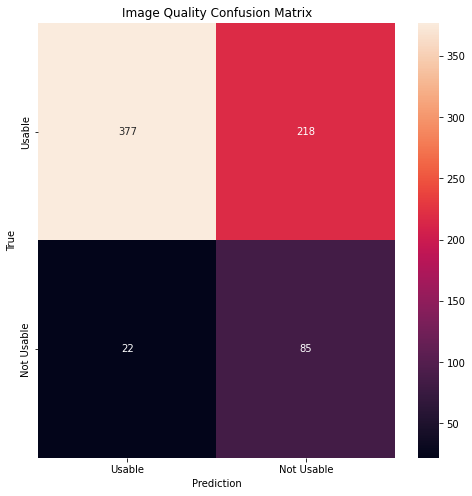

In [10]:
import seaborn as sns
labels = ["Usable","Not Usable"]
conf_matrix = confusion_matrix(y_test_anomaly,y_pred_anomaly)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Image Quality Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Prediction')
plt.show()